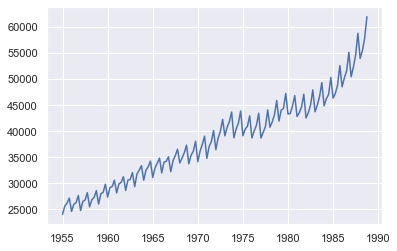

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.datasets import get_rdataset
# Nicer plots than standard matplotlib
sns.set()
# Load and visualise dataset
uk = get_rdataset('UKNonDurables', 'AER')
uk = uk.data
plt.plot(uk.time, uk.value)
plt.show()

In [2]:
timeline = [np.datetime64('1955-01') + np.timedelta64(3*i, 'M') for i in range(len(uk))]
uk['datetime'] = pd.Series(timeline)

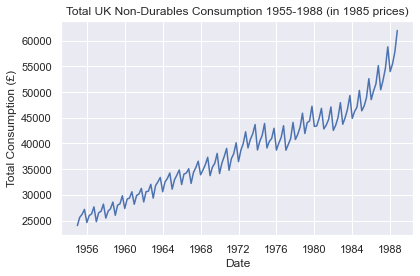

In [3]:
fig, ax = plt.subplots()
ax.plot(uk.datetime, uk.value)
ax.set(xlabel='Date', ylabel='Total Consumption (£)',
        title='Total UK Non-Durables Consumption 1955-1988 (in 1985 prices)')
plt.tight_layout()
plt.savefig('UKNonDurables Full')
plt.show()

In [4]:
train = uk.loc[uk.time < 1980].value.copy()
val = uk.loc[uk.time >= 1980].value.copy()

# ARIMA

In [5]:
from statsmodels.tsa.arima.model import ARIMA

def plot_arima_model(order=(0, 0, 0), 
                    seasonal_order=(0, 0, 0, 0), 
                    savefig=False):
    if seasonal_order == (0, 0, 0, 0):
        title = f'ARIMA{order} Predictions'
    else:
        title = f'SARIMA{order}{seasonal_order} Predictions' 
    arima  = ARIMA(train, order=order, seasonal_order=seasonal_order)
    result = arima.fit()
    # Predict len(val) timesteps into the future
    predictions = result.forecast(steps=len(val))
    # Plot...

    fig, ax = plt.subplots()
    ax.plot(uk.value, 'b', label='Actual')
    ax.plot(predictions, 'r', label='Preds')
    ax.set(xlabel='Date', ylabel='Total Consumption (£)',
            title=title)
    plt.legend()
    plt.tight_layout()
    if savefig:
        plt.savefig(title)
    plt.show()

/Users/king/opt/anaconda3/envs/tabular/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


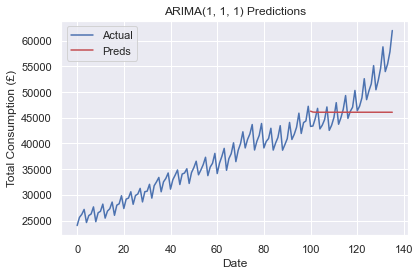

In [6]:
plot_arima_model(order=(1, 1, 1), savefig=True)

/Users/king/opt/anaconda3/envs/tabular/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/king/opt/anaconda3/envs/tabular/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


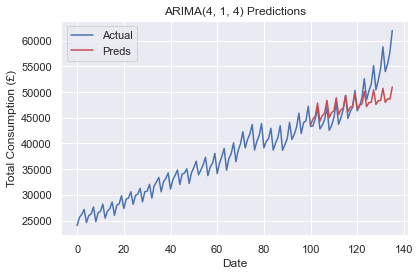

In [7]:
plot_arima_model(order=(4, 1, 4), savefig=True)

# SARIMA

/Users/king/opt/anaconda3/envs/tabular/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/king/opt/anaconda3/envs/tabular/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


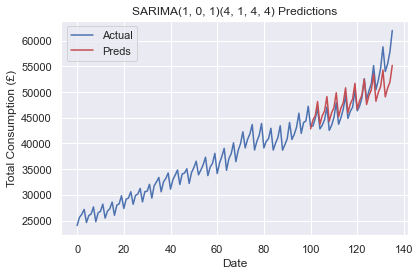

In [8]:
plot_arima_model(order=(1, 0, 1),
                seasonal_order=(4, 1, 4, 4),
                savefig=True)

In [9]:
def plot_preds(preds, title, savefig=False):
    fig, ax = plt.subplots()
    plt.plot(uk.value, 'b', label='Actual')
    plt.plot(preds, 'r', label='Preds')
    ax.set(xlabel='Date', ylabel='Total Consumption (£)',
            title=title)
    plt.legend()

    plt.tight_layout()
    if savefig:
        plt.savefig(title)
    plt.show()

# Unweighted Moving Average

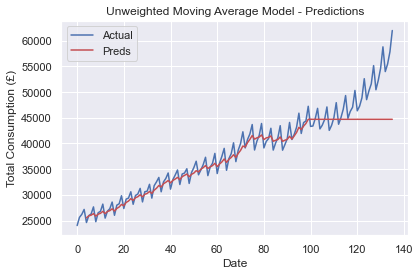

In [10]:
train_df = pd.DataFrame(train)
# Moving avergae window size 5 (chosen arbitrarily)
train_df['MA'] = train_df.rolling(5).mean()
preds = [train_df['MA'].iloc[-1] for _ in range(len(val))]
preds = pd.Series(preds, index=val.index)
preds = train_df.MA.append(preds)

title = 'Unweighted Moving Average Model - Predictions'
plot_preds(preds, title, savefig=True)

# Simple Exponential Smoothing

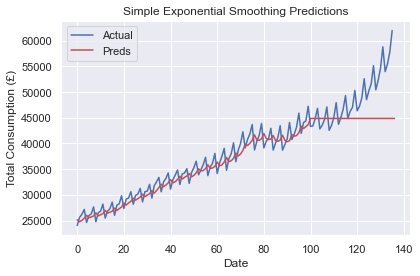

In [11]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

exp_smooth = SimpleExpSmoothing(train, initialization_method='estimated')
res_exp_smooth = exp_smooth.fit()

preds = res_exp_smooth.predict(start=0, end=len(train)+len(val))
title = 'Simple Exponential Smoothing Predictions'

plot_preds(preds, title, savefig=True)

# Holt's Exponential Smoothing

/Users/king/opt/anaconda3/envs/tabular/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


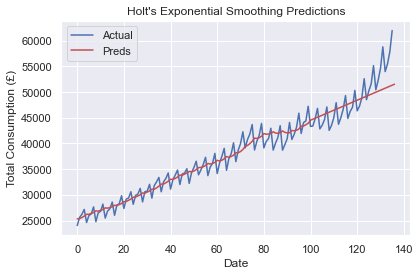

In [12]:
from statsmodels.tsa.holtwinters import Holt

holt = Holt(train, initialization_method='estimated')
res_holt = holt.fit()

preds = holt.predict(res_holt.params, start=0, end=len(train)+len(val))
title = "Holt's Exponential Smoothing Predictions"

plot_preds(preds, title, savefig=True)

# Holt's ES damped_trend=True

/Users/king/opt/anaconda3/envs/tabular/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


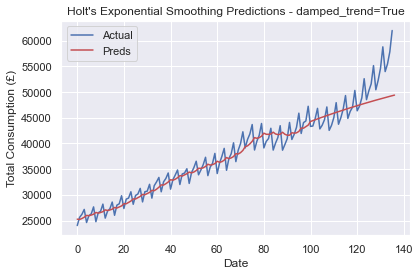

In [13]:
from statsmodels.tsa.holtwinters import Holt

holt = Holt(train, initialization_method='estimated',
        damped_trend=True)
res_holt = holt.fit()

preds = holt.predict(res_holt.params, start=0, end=len(train)+len(val))
title = "Holt's Exponential Smoothing Predictions - damped_trend=True"

plot_preds(preds, title, savefig=True)

# Holt Winter's Exponential Smoothing

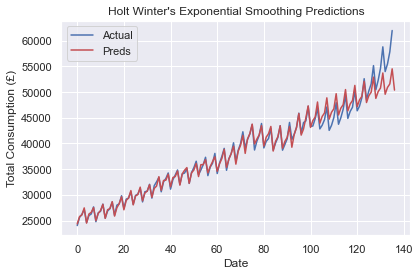

In [14]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

hw_exp_smooth = ExponentialSmoothing(train, 
                                     initialization_method='estimated',
                                     trend='add',
                                     seasonal='add',
                                     seasonal_periods=4)

res_hw_exp_smooth = hw_exp_smooth.fit()

preds = hw_exp_smooth.predict(res_hw_exp_smooth.params, 
                                start=0, end=len(train)+len(val))
title = "Holt Winter's Exponential Smoothing Predictions"
plot_preds(preds, title, savefig=True)